## 1) PACKAGES AND LIBRARIES INSTALLATION 
(TO DO: explain why we need each package)

In [1]:
!pip install 'plotnine[all]'
!pip install spacy
!python -m spacy download en
!pip install -U textblob
!python -m textblob.download_corpora

     |████████████████████████████████| 9.2MB 2.7MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
Requirement already up-to-date: textblob in /usr/local/lib/python3.6/dist-packages (0.15.3)
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/c

In [0]:
import pandas as pd
import numpy as np
from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns
import re
from spacy.lang.en import English
from textblob import TextBlob

## 2) DATABASE
`tweets` is our **main dataset**, the other ones are not used by the moment.

In [0]:
# The dataset from Kaggle:
tweets = pd.read_csv("https://raw.githubusercontent.com/SarahBuechner/DMML2019_Team_Google/master/Database/Tweets.csv")
AAL = pd.read_csv("https://raw.githubusercontent.com/SarahBuechner/DMML2019_Team_Google/master/Database/AAL.csv")
DAL = pd.read_csv("https://raw.githubusercontent.com/SarahBuechner/DMML2019_Team_Google/master/Database/DAL.csv")
LUV = pd.read_csv("https://raw.githubusercontent.com/SarahBuechner/DMML2019_Team_Google/master/Database/LUV.csv")
UAL = pd.read_csv("https://raw.githubusercontent.com/SarahBuechner/DMML2019_Team_Google/master/Database/UAL.csv")

In [11]:
# Dataframe tweets shape
print(tweets.shape)

# Data types
print(tweets.dtypes)

(14640, 15)
tweet_id                          int64
airline_sentiment                object
airline_sentiment_confidence    float64
negativereason                   object
negativereason_confidence       float64
airline                          object
airline_sentiment_gold           object
name                             object
negativereason_gold              object
retweet_count                     int64
text                             object
tweet_coord                      object
tweet_created                    object
tweet_location                   object
user_timezone                    object
dtype: object


## 3) DATA CLEANING
*May be we can include here the data cleaning from Machine Learning section*

In [12]:
# Drop the columns we don't use
tweets = tweets.drop(columns=['airline_sentiment_gold', 'negativereason_gold', 'tweet_coord', 'user_timezone'])

# Statistical summary of the DataFrame, with quartiles, median, etc.
print(tweets[['airline_sentiment_confidence', 'negativereason_confidence']].describe())

       airline_sentiment_confidence  negativereason_confidence
count                  14640.000000               10522.000000
mean                       0.900169                   0.638298
std                        0.162830                   0.330440
min                        0.335000                   0.000000
25%                        0.692300                   0.360600
50%                        1.000000                   0.670600
75%                        1.000000                   1.000000
max                        1.000000                   1.000000


## 4) EXPLORATORY DATA ANALYSIS

### 4.1) Sentiment Analysis by Airline
We want to visualize the **distribution sentiment analysis by company**.


The most common class is negative mood = 62.69%


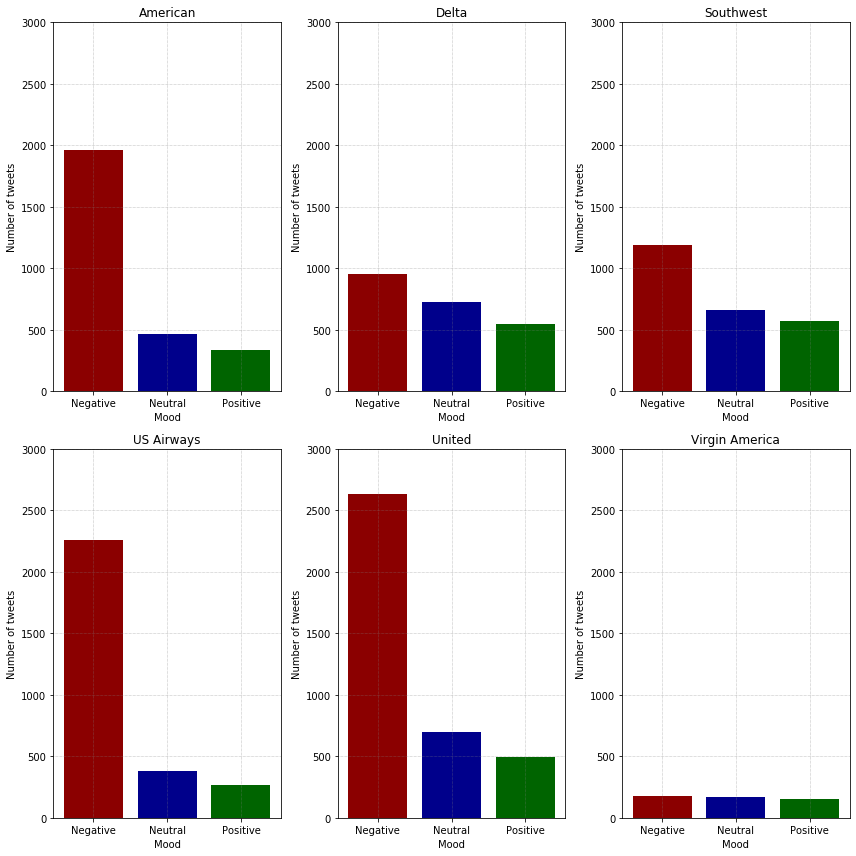

In [13]:
def sentiment_by_airline(Airline):
  df=tweets[tweets['airline']==Airline]
  count=df['airline_sentiment'].value_counts()
  Index = [1,2,3]
  plt.bar(Index,count,color=['darkred', 'darkblue', 'darkgreen'])
  plt.xticks(Index,['Negative','Neutral','Positive'])
  plt.ylabel('Number of tweets')
  plt.xlabel('Mood')
  plt.title(Airline)
  plt.ylim(0,3000)
  plt.grid(which='major', linestyle=':', linewidth='0.5', color='grey')

airlines = ["American", "Delta", "Southwest", "US Airways", "United", "Virgin America"]
plt.figure(1,figsize=(12, 12))


for airline in airlines:
  plt.subplot(231 + airlines.index(airline))
  sentiment_by_airline(airline)
plt.tight_layout()

count=tweets['airline_sentiment'].value_counts()
print("The most common class is negative mood = "+"{:.2%}".format(count[0]/sum(count[0:3])))


### 4.2) Negative Reason by Airline
In the previous graph we saw that the most common class was the *Negative mood*. Now we want to visualize the **negative ratings clustered on topics**.

The 3 main negative topics of American are: (1) Customer Service Issue, (2) Late Flight and (3) Cancelled Flight
The 3 main negative topics of Delta are: (1) Late Flight, (2) Customer Service Issue and (3) Can't Tell
The 3 main negative topics of Southwest are: (1) Customer Service Issue, (2) Cancelled Flight and (3) Can't Tell
The 3 main negative topics of US Airways are: (1) Customer Service Issue, (2) Late Flight and (3) Can't Tell
The 3 main negative topics of United are: (1) Customer Service Issue, (2) Late Flight and (3) Can't Tell
The 3 main negative topics of Virgin America are: (1) Customer Service Issue, (2) Flight Booking Problems and (3) Can't Tell


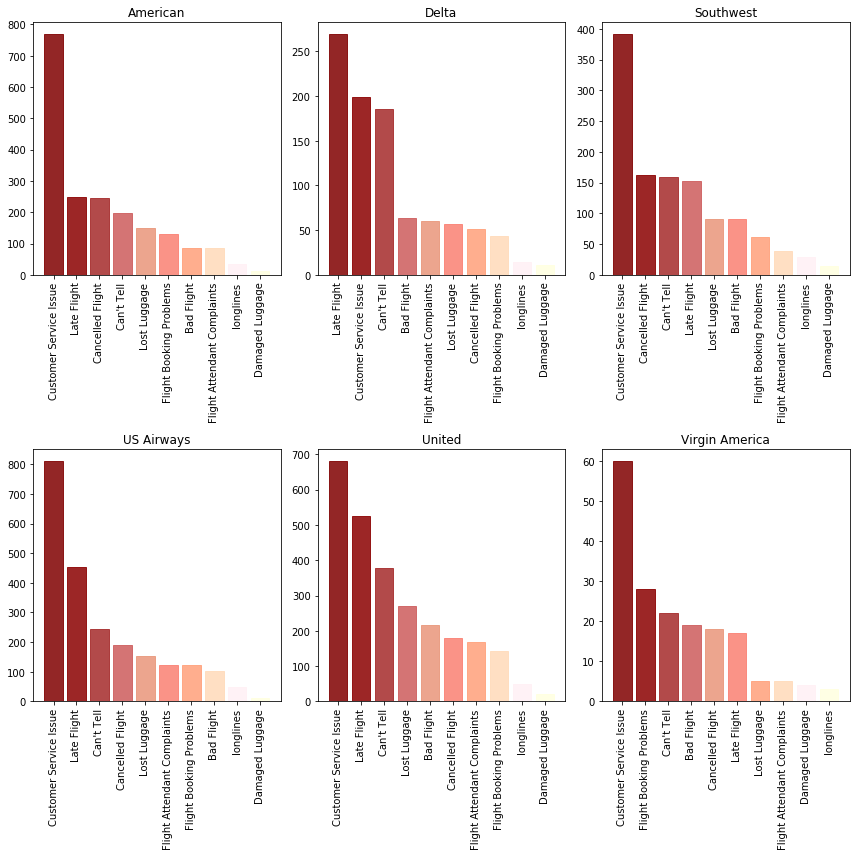

In [14]:
cmap = ['maroon', 'darkred', 'brown', 'indianred', 'darksalmon', 'salmon', 'lightsalmon', 'peachpuff', 'lavenderblush', 'lightyellow']
def negative_reason(Airline):
  df=tweets[tweets['airline']== Airline]
  Neg_reasons_values = df['negativereason'].value_counts(sort=True)
  Neg_reasons_labels = dict(df['negativereason'].value_counts(sort=True))
  Index = range(len(Neg_reasons_values))
  barplot = plt.bar(Index,Neg_reasons_values, alpha = 0.85)
  
  plt.xticks(Index,Neg_reasons_labels, rotation = 90)
  plt.title(Airline)

  for color in cmap:
    barplot[cmap.index(color)].set_color(color)
  
  return ("The 3 main negative topics of " + Airline + " are: (1) " + list(Neg_reasons_labels.keys())[0] + 
  ", (2) " + list(Neg_reasons_labels.keys())[1] + " and (3) " + list(Neg_reasons_labels.keys())[2])


airlines = ["American", "Delta", "Southwest", "US Airways", "United", "Virgin America"]
plt.figure(1,figsize=(12, 12))

for airline in airlines:
  plt.subplot(231 + airlines.index(airline))
  print(negative_reason(airline))

plt.tight_layout()



### 4.3) Tweet volum per day


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

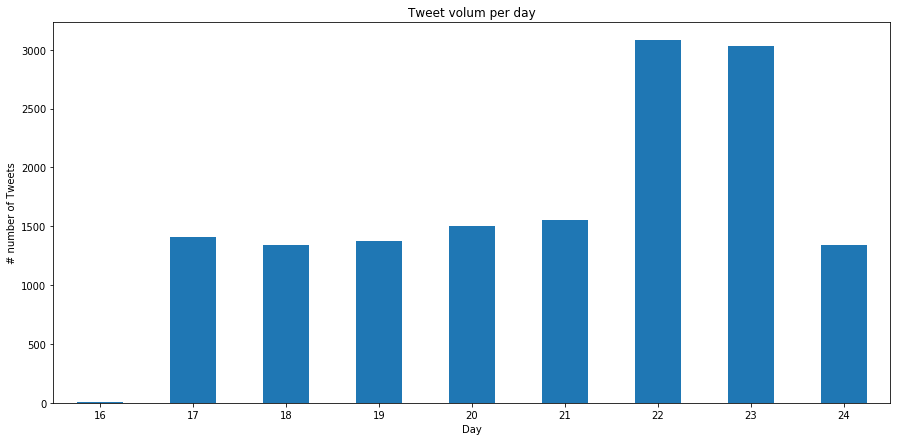

In [25]:
tweets['tweet_created'] = pd.to_datetime(tweets['tweet_created'])
X = tweets['tweet_created']

fig, ax = plt.subplots(figsize=(15,7))
X.groupby([X.dt.day]).count().plot(kind="bar")
ax.set_title('Tweet volum per day')
ax.set_ylabel("# number of Tweets")
ax.set_xlabel("Day")
plt.xticks(rotation = 0)


### 4.4) Tweet volum per hour and per day


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0, 0.5, '# number of Tweets')

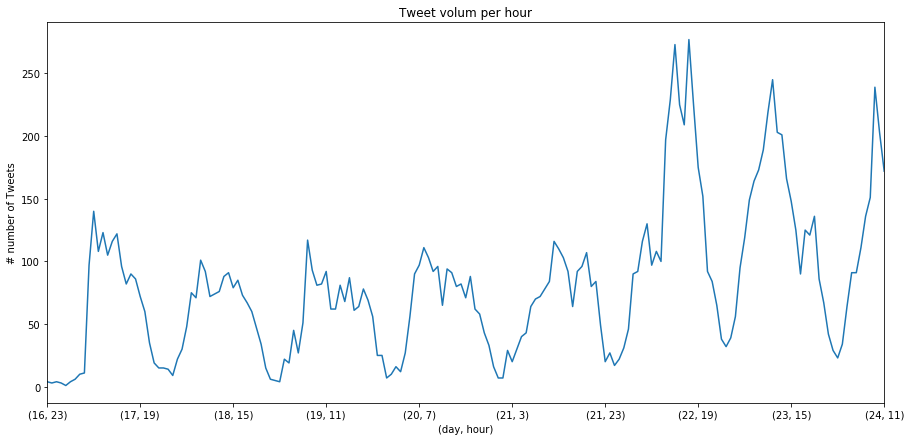

In [26]:
df = tweets[['tweet_created', 'airline_sentiment_confidence']]
df['tweet_created'] = pd.to_datetime(df['tweet_created'])
X = df['tweet_created']

fig, ax = plt.subplots(figsize=(15,7))
X.groupby([X.dt.day,X.dt.hour]).count().plot(ax=ax)
ax.set_title('Tweet volum per hour')
ax.set_xlabel("(day, hour)")
ax.set_ylabel("# number of Tweets")


### 4.5) Stock market
*NOT IMPLEMENTED YET*

In [0]:
# Preparing the dataset
"""X_AAL = pd.to_datetime(AAL["Date"])
y_AAL = (AAL["Low"] + AAL["High"])/2
X_DAL = DAL["Date"]
y_DAL = (DAL["Low"] + DAL["High"])/2

# Initialize the data
data = pd.DataFrame(data={'Date': X_AAL, 'Avg Price': y_AAL})

# Create an lineplot
plt.figure(figsize=(15,7))
sns.lineplot(x="Date", y="Avg Price", data=data)
plt.title("American Airlines (AAL)")
plt.show()"""

### 4.6) World cloud

In [0]:
!pip install wordcloud
from wordcloud import WordCloud,STOPWORDS

#### 4.6.1) Draw wordcloud function

The function **`draw_wordcloud`** allows the user to *show* the drawcloud according the sentiment:

**Arguments**: 
*   `sentiment`: string string representing the sentiment(positive, negative, neutral). 

In [0]:
def draw_wordcloud(sentiment):
    sentiment_tweets  =tweets[tweets['airline_sentiment']== sentiment]
    words = ' '.join(sentiment_tweets['text'])
    cleaned_word = " ".join([word for word in words.split() if 'http' not in word and not word.startswith('@') and word != 'RT'])
    wordcloud = WordCloud(stopwords=STOPWORDS,background_color='white',width=3000, height=2500).generate(cleaned_word)
    plt.figure(1,figsize=(15,15))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

In [0]:
draw_wordcloud('negative')

In [0]:
draw_wordcloud('positive')

In [0]:
draw_wordcloud('neutral')

## 5) DATA MINING AND MACHINE LEARNING

### 5.1) Filter tweets function

The function **`filter_tweets`** allows the user to *tokenize* the tweet removing the *noise*:

**Tokens removed**:
*   Stop words
*   Punctuation
*   Tokens with less than 3 characters
*   Tokens containing a non alphabet character (i.e. "/", "@", etc.)

Then the trailing whitespaces are removed from the token using `strip()` and finally is converted to a lowercase word using `lower()`. If after removing the not desired tokens the `filtered_tweet` is empty, we do not include it into the `list_filtered_tweets`.

**Arguments**: 
*   `list_tweets`: array containing the tweets. 
*   `number_observations`: how many observations we want to treat (it will be removed in the future but now is usefull)

In [0]:
def filter_tweets(list_tweets, number_observations):  # TO DO: zip with account_name
    list_filtered_tweets = []

    for tweet in list_tweets[:number_observations]:
        filtered_tweet = []
        sentence = English()(tweet)

        for word in sentence:
            #if len(word) > 2 and not word.is_stop and word.is_alpha:
            if not word.is_stop:
                filtered_tweet.append(word.string.strip().lower())
        
        if len(filtered_tweet) != 0:
            list_filtered_tweets.append(filtered_tweet)
            
    return list_filtered_tweets

Here an example where the first 200 tweets from the dataframe `tweets` are filtered.

> Indented block



In [0]:
filter_tweets_sample = filter_tweets(list(tweets["text"]), 200)
for tweet_filtered in filter_tweets_sample:
  print(tweet_filtered)

In [0]:
#Adding filtered tweets to our dataset (here we only filtered out stop words)
table_200_lines = tweets[:200]
table_200_lines["filtered_tweets"] = filter_tweets_sample
print(table_200_lines)

### 5.2) Search group function

The function **`search_group_classes`** allows the user to classify tweets by passangers classes:

**Context**:
From a business perspective, the company needs to prioritize which customer needs to be replied to firstly. The idea, is to create several classes and then sort based on priority. In the ideal world, this priority will be based on ticket price but this information cannot be inferred.

- The first approach is to classify into 2 classes: **business class** and **not business class** only using the tweet text (i.e.: type of words in the tweet, orthography, etc.)

- The second approach is to figure out what is the scope of the tweet. For instance, if the account is verified, or the complaint is made by a very popular account (with a lot of followers) the complaint needs to be dealt quickly. *(NOT IMPLEMENTED)*

**Arguments**: 
*   `airline_sentiment`: determines the sentiment analysis we want to work with. Possible values: `('positive', 'negative', 'neutral')` 
*   `list_words`: words that define the group class, i.e.`("business class|first class|priority|preference")`

In [0]:
def search_group_classes(airline_sentiment, list_words):
    df_neg = (tweets[tweets['airline_sentiment'] == airline_sentiment])
    list_tweets = df_neg["text"]

    output = []
    for tweet in list_tweets:
        if re.findall(list_words, tweet):
            output.append(tweet)

    return output

Here we want to gathered the **business class tweets** from the dataset `tweets`.

In [0]:
business_class = ("business class|first class|priority|preference")
business_class_tweets = search_group_classes("negative", business_class)
for bc_tweet in business_class_tweets:
    print(bc_tweet)

### 5.3) Tweet sentiment analysis

The function **`tweet_sentiment_analysis`** computes the sentiment analysis of each tweet `polarity` and `subjectivity` and then sorts the bunch of tweets based on the polarity level of the tweet *(NOT IMPLEMENTED)*

> **Polarity** : Polarity is a float value within the range `[-1.0 to 1.0]` where 0 indicates neutral, +1 indicates a very positive sentiment and -1 represents a very negative sentiment.

> **Subjectivity**: Subjectivity is a float value within the range `[0.0 to 1.0]` where 0.0 is very objective and 1.0 is very subjective. 

In [0]:
def tweet_sentiment_analysis(filter_tweets_class):
    filter_tweets_string = []
    results = []
    sentiment_polarity = []
    sentiment_subjectivity = []

    # Converting the tokens list to a string
    for tweet in filter_tweets_class:
        filter_tweets_string.append(" ".join([word for word in tweet]))

    # Computing the sentiment analysis, applying method correct() to attempt spelling correction
    for tweet_filtered in filter_tweets_string:
        sentiment_polarity.append(TextBlob(tweet_filtered).correct().sentiment.polarity)
        sentiment_subjectivity.append(TextBlob(tweet_filtered).correct().sentiment.subjectivity)
        results.append(tweet_filtered)

    return list(zip(sentiment_polarity, sentiment_subjectivity, results))

In [0]:
def sentiment_analysis_with_text_blob(tweet_to_be_classified): #here we use unfiltered tweets because TextBlob filters them 
    list_sentiments = []

    for element in tweet_to_be_classified:
        list_sentiments.append(TextBlob(element).sentiment)
        
    return list_sentiments

Here an example for the first 100 tweets from our dataframe "tweets"

> 

In [0]:
list_sentiments = sentiment_analysis_with_text_blob(tweets["text"]) 

In [0]:
sentiment_table = pd.DataFrame(list_sentiments)
print(sentiment_table)

Now are are going to conver the sentiment data we found into strings.
Such that: 
* -1 <= polarity < 0  => the tweet is negative <br>
* polarity = 0        => the tweet is neutral <br>
* 0 < polarity <= 1   => the tweet is positive <br>

Subjectivity ϵ {0, 1}
* 0 < subjectivity <= 0.5   => the tweet is objective <br>
* 0.5 < subjectivity <= 1   => the tweet is subjective <br>

=> Note: This is a subjective choice and can be changed

In [0]:
list_polarity_as_string=[]
for element in sentiment_table["polarity"]:
    if -1 <= element < 0:
        list_polarity_as_string.append("negative")
    elif element == 0:
         list_polarity_as_string.append("neutral")
    else: 
        list_polarity_as_string.append("positive")

#Adding to tweets table
tweets["polarity_string"] = list_polarity_as_string
print(tweets)

In [0]:
#Conversion
sentiment_equal = []
for element in zip(tweets["airline_sentiment"],tweets["polarity_string"]):
    if element[0]==element[1]:
        sentiment_equal.append(1)
    else:
        sentiment_equal.append(0)     


Here we are counting the number of sentiments that are the same than the ones provided by the dataset

In [0]:
number_equal_sentiment = 0
for element in zip(tweets["airline_sentiment"],tweets["polarity_string"]):
    if element[0]==element[1]:
        number_equal_sentiment += 1 
print("We estimated", number_equal_sentiment, "sentiments in the same way as the sentiments provided by the data set.")

In [0]:
#ratio = number_equal_sentiment/total nbr of tweets
ratio = number_equal_sentiment/(len(tweets))
print("The ratio of equal sentiments is of {:.2%}".format(ratio))

In [0]:
filter_tweets_bc = filter_tweets(business_class_tweets, len(business_class_tweets))
"""for tweet_filtered in filter_tweets_bc:
      print(tweet_filtered)"""

sentiment_analysis_class = tweet_sentiment_analysis(filter_tweets_bc)
for tweet in sentiment_analysis_class:
        print(tweet)

# TO DO: sort the tweets based on polarity and add account_name

*TO DO: implement N-gramms*